In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 24.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import rasterio
from datetime import datetime, timedelta
from scipy.ndimage import map_coordinates
from tqdm import tqdm_notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gedi = pd.read_parquet('/content/drive/MyDrive/geog642/gedi.parquet')
gedi.keys()

Index(['delta_time', 'shot_number', 'digital_elevation_model',
       'lat_lowestmode', 'lon_lowestmode', 'fhd_normal', 'cover_z_000',
       'pai_z_000', 'elev_lowestmode', 'agbd', 'wsci_pft', 'quality_flag',
       'rh_opt_090', 'rh_opt_095', 'rh_opt_098', 'geometry'],
      dtype='object')

In [ ]:
# Create a date variable
start_date = datetime(2018, 1, 1, 0, 0, 0) # (year, month, day, hour, minute, second)

# Add seconds to the date variable
shot_dates = [start_date + timedelta(seconds=x) for x in gedi['delta_time'].values]
shot_dates = np.array(shot_dates)

# Display the original and updated dates
print("Original Date:", start_date)
print("New Date:", shot_dates[0:5])

Original Date: 2018-01-01 00:00:00
New Date: [datetime.datetime(2020, 12, 6, 23, 37, 39, 260693)
 datetime.datetime(2020, 12, 6, 23, 37, 39, 252429)
 datetime.datetime(2020, 12, 6, 23, 37, 39, 244165)
 datetime.datetime(2022, 11, 20, 22, 19, 2, 330337)
 datetime.datetime(2021, 5, 6, 5, 22, 4, 10289)]


In [ ]:
ind = np.logical_and(shot_dates>datetime(2020, 12, 1, 0, 0, 0), shot_dates<datetime(2021, 4, 1, 0, 0, 0))
print(np.sum(ind))
np.max(gedi['delta_time'].values[ind])

20484


101713161.3965786

In [ ]:
lat = gedi['lat_lowestmode'].values[ind]
lon = gedi['lon_lowestmode'].values[ind]
abgd = gedi['agbd'].values[ind]
height = gedi['rh_opt_098'].values[ind]

In [ ]:
with rasterio.open('/content/drive/MyDrive/geog642/20130414_processed.tif', 'r') as src:
  profile13 = src.profile
  img13 = src.read()

with rasterio.open('/content/drive/MyDrive/geog642/20210130_processed.tif', 'r') as src:
  profile21 = src.profile
  img21 = src.read()
  # Transform latitudes and longitudes to pixel coordinates
  xs, ys = rasterio.transform.rowcol(src.transform, lon, lat)
  # Round to integers as pixel coordinates are integers
  xs = np.round(xs)#.astype(int)
  ys = np.round(ys)#.astype(int)
  # values = src.read(window=((ys[0], ys[0]+1), (xs[0], xs[0]+1)))

In [ ]:
mask = ~np.isnan(img21[0])
print(mask.shape)
plt.imshow(mask, cmap='gray')

(2896, 3811)


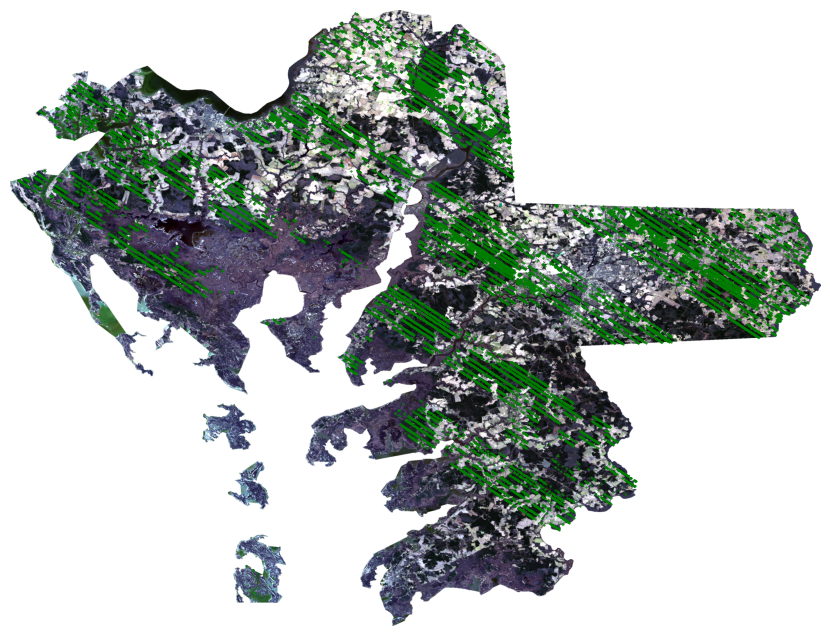

In [ ]:
plt.figure(figsize=(12, 8))
im_to = img21[3:0:-1].transpose(1, 2, 0)
ind_to = np.isnan(im_to)
im_to[ind_to] = 1
plt.imshow(im_to)
plt.plot(ys, xs, 'go', markersize=0.5)
plt.axis('off')
plt.show()

In [ ]:
# X = np.array([img21[:, x, y] for int(x), int(y) in zip(xs, ys)])
X = np.array([map_coordinates(band, [xs, ys], order=0, mode='nearest') for band in img21]).T
filter = np.prod(~np.isnan(X), axis=1).astype('bool')
Y = abgd
# Y = (Y - Y.min()) / (Y.max() - Y.min())

x_train, x_test, y_train, y_test = train_test_split(X[filter], Y[filter], test_size=0.2, random_state=10)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(16387, 14) (4097, 14)
(16387,) (4097,)


In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)
result = model.predict(x_test)

r2 = metrics.r2_score(result, y_test)
rmse = np.sqrt(metrics.mean_squared_error(result, y_test))

print('r2: ', r2)
print('rmse: ', rmse)
print('rmse %: ', rmse/(y_test.max() - y_test.min()))
print('rmse %: ', rmse/(Y.max() - Y.min()))

r2:  -1.857945657834125
rmse:  59.241222
rmse %:  0.042755906
rmse %:  0.042755906


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    # n_estimators=10,
    # max_depth=1
    )
rf.fit(x_train, y_train)
result = rf.predict(x_test)

r2 = metrics.r2_score(result, y_test)
rmse = np.sqrt(metrics.mean_squared_error(result, y_test))

print('r2: ', r2)
print('rmse: ', rmse)
print('rmse %: ', rmse/(y_test.max() - y_test.min()))
print('rmse %: ', rmse/(Y.max() - Y.min()))
print('rmse %: ', rmse/np.mean(y_test))

r2:  -1.0591763098642364
rmse:  58.11570607322218
rmse %:  0.04194359000771644
rmse %:  0.04194359000771644
rmse %:  0.5242279066420266


In [ ]:
pred21 = rf.predict(img21[:, mask].T)
biomass21 = np.full(mask.shape, np.nan, dtype='float32')
biomass21[mask] = pred21

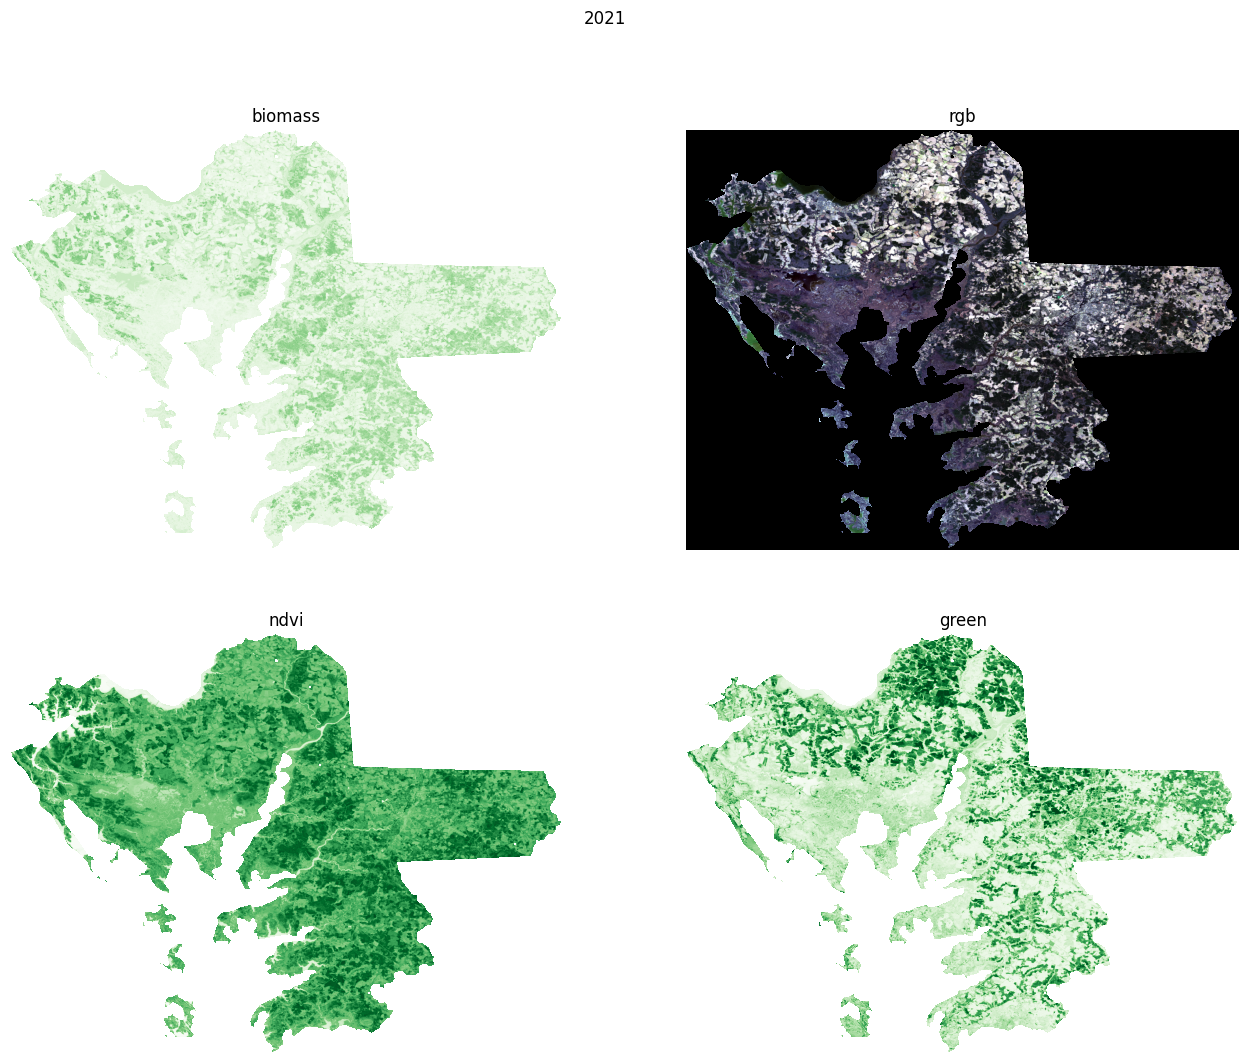

In [ ]:
plt.figure(figsize=(16, 12))
plt.suptitle('2021')
plt.subplot(221)
plt.imshow(biomass21, cmap='Greens')
plt.title('biomass')
plt.axis('off')

plt.subplot(222)
plt.imshow(img21[3:0:-1].transpose(1, 2, 0))
plt.title('rgb')
plt.axis('off')

plt.subplot(223)
plt.imshow(img21[7], cmap='Greens')
plt.title('ndvi')
plt.axis('off')

plt.subplot(224)
plt.imshow(img21[2], cmap='Greens')
plt.title('green')
plt.axis('off')
plt.show()

In [ ]:
profile = profile21.copy()
profile.update(dtype=np.float32,
                count=1,
                compress='lzw')

with rasterio.open('/content/drive/MyDrive/geog642/biomass21.tif', 'w', **profile) as dst:
        dst.write_band(1, biomass21)

In [ ]:
mask13 = ~np.isnan(img13[0])
pred13 = rf.predict(img13[:, mask13].T)
biomass13 = np.full(mask13.shape, np.nan, dtype='float32')
biomass13[mask13] = pred13

In [ ]:
plt.figure(figsize=(16, 12))
plt.suptitle('2013')
plt.subplot(221)
plt.imshow(biomass13, cmap='Greens')
plt.title('biomass')
plt.axis('off')

plt.subplot(222)
plt.imshow(img13[3:0:-1].transpose(1, 2, 0))
plt.title('rgb')
plt.axis('off')

plt.subplot(223)
plt.imshow(img13[7], cmap='Greens')
plt.title('ndvi')
plt.axis('off')

plt.subplot(224)
plt.imshow(img13[2], cmap='Greens')
plt.title('green')
plt.axis('off')
plt.show()

In [ ]:
profile = profile13.copy()
profile.update(dtype=np.float32,
                count=1,
                compress='lzw')

with rasterio.open('/content/drive/MyDrive/geog642/biomass13.tif', 'w', **profile) as dst:
        dst.write_band(1, biomass13)

In [ ]:
np.sum(pred13)-np.sum(pred21)

3114770.663534999

In [ ]:
with rasterio.open('/content/drive/MyDrive/geog642/biomass13.tif', 'r') as dst:
        img13 = dst.read(1)

with rasterio.open('/content/drive/MyDrive/geog642/biomass21.tif', 'r') as dst:
        img21 = dst.read(1)

In [ ]:
img21.dtype

dtype('float32')

In [ ]:
import fiona

In [ ]:
with fiona.open('/content/drive/MyDrive/geog642/low 2100/Low_2100_SWI_dissolve.shp', "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

from rasterio import mask
with rasterio.open('/content/drive/MyDrive/geog642/biomass21.tif', 'r') as dst:
        out_image, out_transform = rasterio.mask.mask(dst, geoms, crop=False, invert=False)




In [ ]:
img13.shape

(2896, 3811)

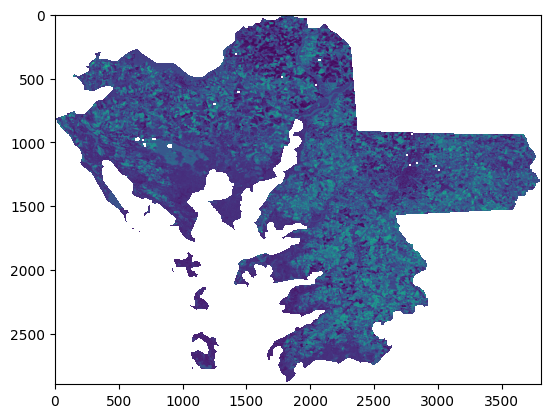

In [ ]:
plt.imshow(img13)

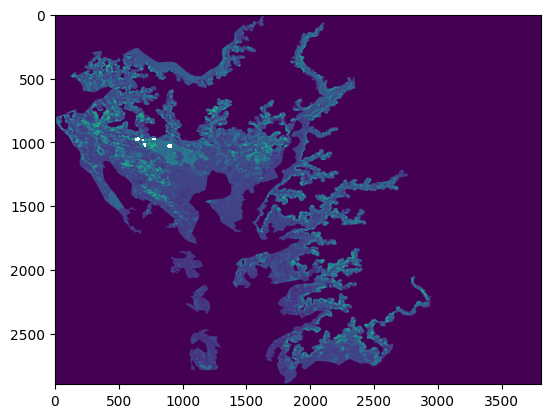

In [ ]:
plt.imshow(out_image[0])

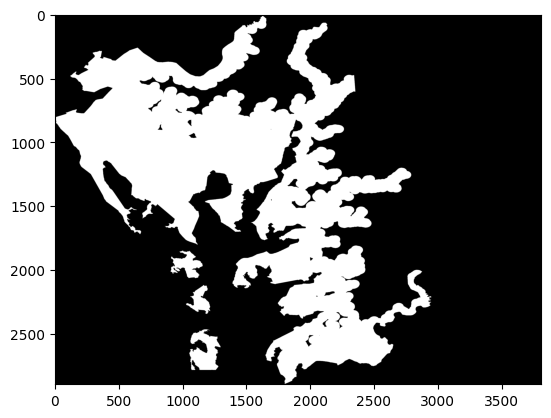

In [ ]:
mask1 = out_image[0]!=0
mask2 = ~np.isnan(out_image[0])
mask = np.logical_and(mask1, mask2)

plt.imshow(mask, cmap='gray')

In [ ]:
print(np.sum(out_image[0, mask]))
print(np.min(out_image[0, mask]))
print(np.max(out_image[0, mask]))
print(np.mean(out_image[0, mask]))

226236560.0
7.8175936
351.15503
74.70118


In [ ]:
np.sum(img13[~np.isnan(img13)])

383850700.0

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14,)),
    tf.keras.layers.Dense(units=12, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear'),
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

history = model.fit(x_train, np.expand_dims(y_train, axis=-1),
                    validation_data=(x_test, np.expand_dims(y_test, axis=-1)),
                    epochs=30,
                    verbose=1)

result = model.predict(x_test)

r2 = metrics.r2_score(result, y_test)
rmse = np.sqrt(metrics.mean_squared_error(result, y_test))

print('r2: ', r2)
print('rmse: ', rmse)
print('rmse %: ', rmse/(y_test.max() - y_test.min()))
print('rmse %: ', rmse/(Y.max() - Y.min()))

Epoch 1/30
513/513 [==============================] - 5s 5ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 2/30
513/513 [==============================] - 2s 4ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 3/30
513/513 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 4/30
513/513 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 5/30
513/513 [==============================] - 2s 3ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/30
513/513 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/30
513/513 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/30
513/513 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/30
513/513 [==============================] - 2s 4ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/30
513/513 [==============================] - 2s 4ms/step - loss: 0.0017 - val_loss: 0.0019